In [1]:
import numpy as np
import matplotlib.pyplot as plt
import caffe

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
import os

caffe_root = '/data3/ludi/local/caffe/'
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found


In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def, model_weights, caffe.TEST)

In [5]:
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)
print 'mean-subtracted values: ', zip('BGR', mu)

transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2, 1, 0))

mean-subtracted values:  [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [6]:
tuple(net.blobs['data'].shape)

(10, 3, 227, 227)

In [7]:
net.blobs['data'].reshape(50, 3, 227, 227)

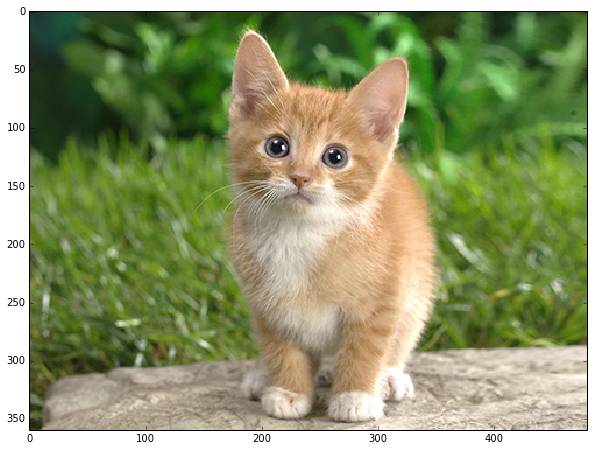

In [8]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [31]:
net.blobs['data'].data[...] = transformed_image
output = net.forward()
output_prob = output['prob'][0]
print 'predicted class is:', output_prob.argmax()

 predicted class is: 281


In [32]:
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print'output label:', labels[output_prob.argmax()]

output label: n02123045 tabby, tabby cat


In [33]:
top_ind = output_prob.argsort()[::-1][:5]
print 'probability and labels'
zip(output_prob[top_ind], labels[top_ind])

probability and labels


[(0.31243584, 'n02123045 tabby, tabby cat'),
 (0.2379715, 'n02123159 tiger cat'),
 (0.12387265, 'n02124075 Egyptian cat'),
 (0.10075713, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957303, 'n02127052 lynx, catamount')]

In [34]:
%timeit net.forward()

1 loops, best of 3: 6.67 s per loop


In [35]:
caffe.set_device(0)
caffe.set_mode_gpu()
net.forward()
%timeit net.forward()

10 loops, best of 3: 51.9 ms per loop


In [36]:
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


In [38]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


In [39]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

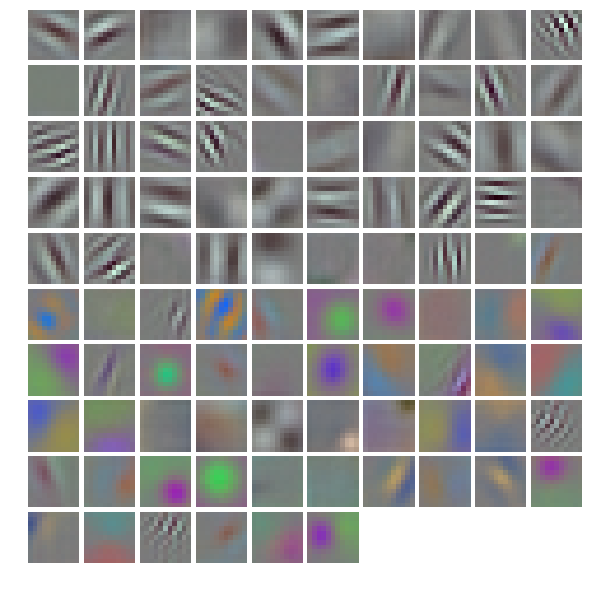

In [40]:
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

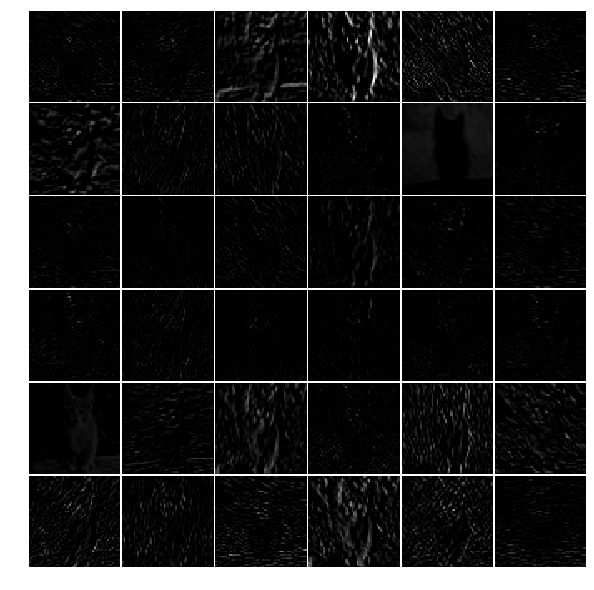

In [46]:
feat = net.blobs['conv1'].data[2, :36]
vis_square(feat)

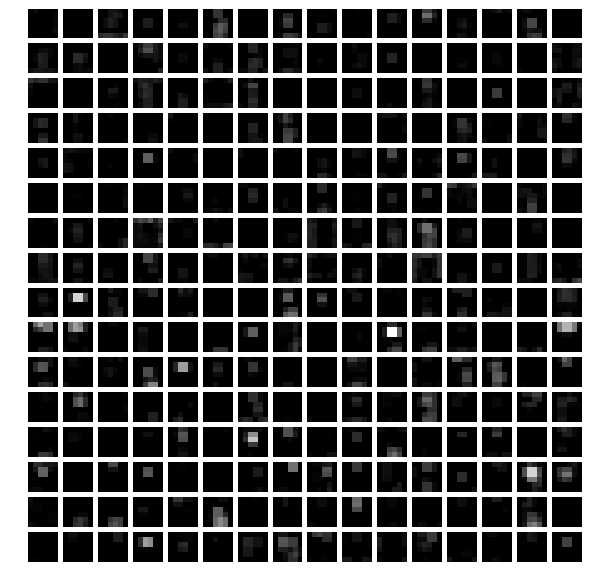

In [47]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

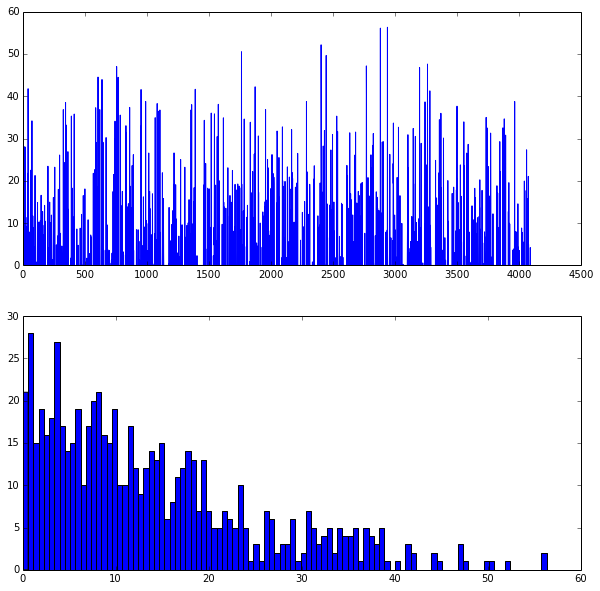

In [53]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

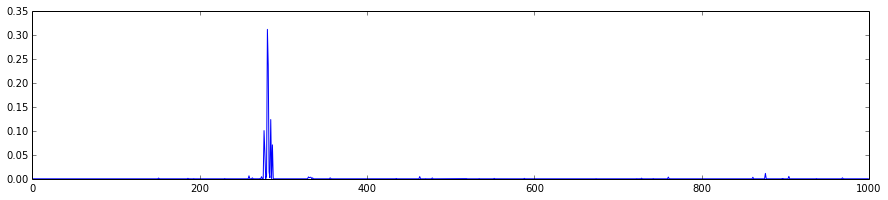

In [54]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

--2017-10-09 17:24:58--  http://pic2.cxtuku.com/00/00/24/b77547da0628.jpg
Resolving pic2.cxtuku.com (pic2.cxtuku.com)... 165.254.60.146, 2405:fd80:110:0:d63d:7eff:fe73:c46, 2405:fd80:110:0:d63d:7eff:fe73:165a
Connecting to pic2.cxtuku.com (pic2.cxtuku.com)|165.254.60.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74562 (73K) [image/jpeg]
Saving to: ‘image.jpg’

100%[======================================>] 74,562      --.-K/s   in 0.01s   

2017-10-09 17:24:58 (5.76 MB/s) - ‘image.jpg’ saved [74562/74562]

probabilities and labels:


[(0.79531264, 'n02088364 beagle'),
 (0.057576772, 'n02089973 English foxhound'),
 (0.045146819, 'n02089867 Walker hound, Walker foxhound'),
 (0.018194024, 'n02088632 bluetick'),
 (0.0094971014, 'n02088238 basset, basset hound')]

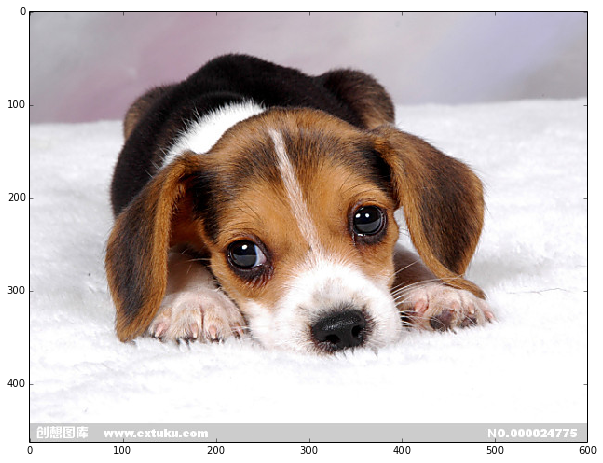

In [55]:
# download an image
my_image_url = "http://pic2.cxtuku.com/00/00/24/b77547da0628.jpg"  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])